# Autonomous Discovery of Physical Laws via Adversarial Surrogates: Rediscovering Kepler’s Laws from Observational Data

Autonomous systems must not only perceive their environment but also reason about the physical and behavioral principles that govern it. This notebook introduces **IRAS (Identifying Regulation with Adversarial Surrogates)**, an algorithm designed to autonomously discover interpretable physical laws from raw observational data.

In this work, we apply IRAS to orbital data from NASA’s Jet Propulsion Laboratory Horizons system. Remarkably, IRAS is able to rediscover **Kepler’s first and third laws of planetary motion**—a feat that mirrors the historical process by which these laws were originally derived from Tycho Brahe’s observations.

IRAS leverages adversarial training to distinguish physically meaningful models from spurious correlations, enabling the extraction of robust and interpretable relationships. This notebook walks through the methodology, implementation, and results, and discusses the current limitations of the approach.

🔗 **Code Repository**: [https://github.com/RonTeichner/IRAS](https://github.com/RonTeichner/IRAS

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import pickle
from kepler_func import *
from IPython.core.display import display, HTML

display(HTML('''
<style>
.output_scroll {
    overflow-x: auto !important;
    overflow-y: visible !important;
    max-height: none !important;
}
</style>
'''))

%matplotlib inline

# Define planet IDs
planets = {
    'Mercury': 199,
    'Venus': 299,
    'Earth': 399,
    'Mars': 499
}

colors = {
        'Mercury': 'gray',
        'Venus': 'orange',
        'Earth': 'blue',
        'Mars': 'red'
    }

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
/var/folders/d2/967f_3k57458fwy_1s1dh8_w0000gn/T/ipykernel_31299/1571377538.py:7: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


## Dataset: Orbital Observations from NASA JPL
To evaluate IRAS, we use high-precision ephemerides from NASA’s **Jet Propulsion Laboratory (JPL) Horizons system**, which provides heliocentric positions and velocities of solar system bodies. These data are derived from radar, optical, and spacecraft tracking measurements.

We retrieved **sparse observations** (one every 30 days over 30 years) for the **inner planets**—Mercury, Venus, Earth, and Mars. Each observation includes the planet’s 3D position and velocity vectors relative to the Sun:

$$
m^{p,k} := \begin{bmatrix}
(r^{p,k})^\top & (v^{p,k})^\top
\end{bmatrix}^\top
$$

where $ r^{p,k} \in \mathbb{R}^3 $ and $ v^{p,k} \in \mathbb{R}^3 $ are the heliocentric position and velocity of planet $ p $ at time $ t^{p,k} $.

In addition, we retrieved **orbital parameters** for approximately 500 small-body orbits from the **JPL Small-Body Database**. Each orbit is represented by:

$$
b^p := \begin{bmatrix}
a^p & e^p & i^p & \Omega^p & \omega^p & T^p
\end{bmatrix}^\top
$$

In [2]:


# Define epoch for orbital elements
epoch = {'start': '2008-01-06', 'stop': '2009-01-06', 'step': '30d'}
# Define observation time range
obs_epochs = {'start': '1993-01-01', 'stop': '2023-01-01', 'step': '30d'}

if not os.path.exists('NASA_data.pkl'):
    orbitalObs_df, orbitalParams_df, true_anomaly_values_df, multi_orbitalParams_df, multi_orbitalObs_df = get_orbital_observations(planets, epoch, obs_epochs)
    with open('NASA_data.pkl', 'wb') as file:
        pickle.dump([orbitalObs_df, orbitalParams_df, true_anomaly_values_df, multi_orbitalParams_df, multi_orbitalObs_df], file)
else:
    dataset = pickle.load(open('NASA_data.pkl', 'rb'))
    orbitalObs_df, orbitalParams_df, true_anomaly_values_df, multi_orbitalParams_df, multi_orbitalObs_df = dataset

    


## The IRAS Algorithm: Discovering Invariants via Adversarial Surrogates

The **Identifying Regulation with Adversarial Surrogates (IRAS)** algorithm is designed to uncover conserved quantities—such as physical laws—from raw observational data. It operates by comparing the behavior of a candidate function \( g \) on real data versus a surrogate dataset where statistical dependencies have been disrupted. Through an adversarial refinement process, IRAS iteratively adjusts both the function and the surrogate distribution to isolate meaningful invariants while avoiding trivial solutions.

The core idea is that a true conservation law will yield a function $ g $ whose output remains stable on real data but varies significantly on the surrogate. This contrast is quantified using the **Coefficient of Regulation (CR)**, and the algorithm minimizes this metric through a dynamic interplay between two components: the **combination player** (which proposes candidate functions) and the **shuffle player** (which adapts the surrogate distribution adversarially).


**Note:** To obtain the results reported in the paper, we performed **multiple runs**, each time tracking the CR on both validation and training sets, a standard practice in model training. We selected the run in which both CR values were **low and similar**, indicating a physically meaningful and generalizable model.  
  
In this notebook, to allow for quick experimentation, we perform **only a single run**. As a result, the outcome may vary between runs and is **not guaranteed** to always match the optimal results shown in the paper.

We now apply IRAS to the **heliocentric coordinates of Mercury** to investigate whether the algorithm can autonomously identify conserved quantities—potentially leading to a rediscovery of **Kepler’s first law**.




In [3]:
if not os.path.exists('IRAS_results.pkl'):
    IRAS_runOnCoordinatesResultsDict = dict()
    enableIRAS_train = True
else:
    IRAS_runOnCoordinatesResultsDict = pickle.load(open('IRAS_results.pkl', 'rb'))
    enableIRAS_train = not 'Mercury' in IRAS_runOnCoordinatesResultsDict.keys()
    
if enableIRAS_train:
    
    IRAS_runOnCoordinatesResultsDict['Mercury'] = runIRAS('Mercury', true_anomaly_values_df, orbitalObs_df, orbitalParams_df, externalReport=True)
    
    
    with open('IRAS_results.pkl', 'wb') as file:
        pickle.dump(IRAS_runOnCoordinatesResultsDict, file)


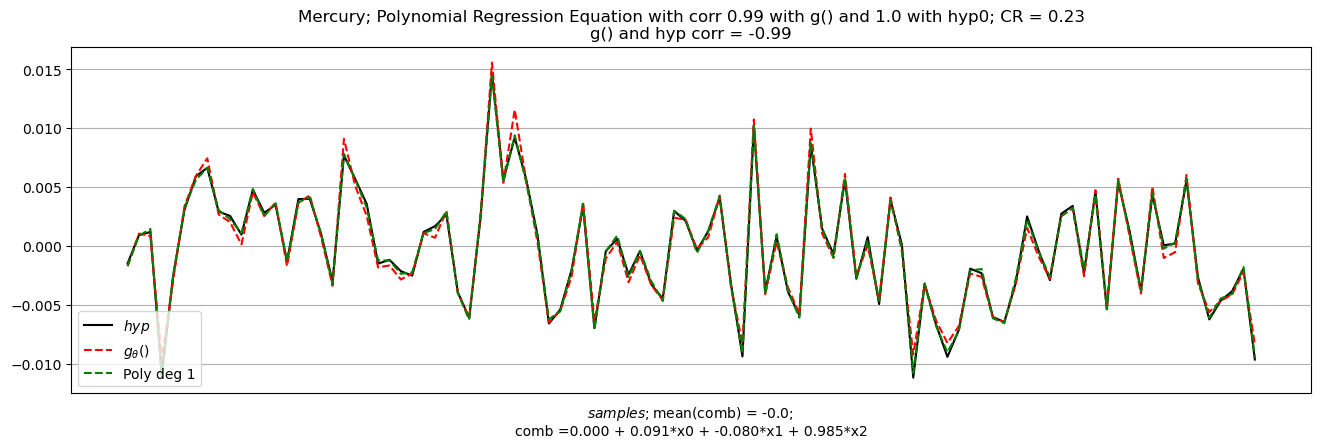

Mercury; GT plane eq: 0=0.000 + 0.091*x + -0.081*y + 0.993*z; IRAS-polyFit eq: 0=0.000 + 0.091*x + -0.080*y + 0.993*z; angle between normals is 0.0454 deg
sanity orbital plane eq: 0=[ 0.          0.09108063 -0.08108878  0.99253661]


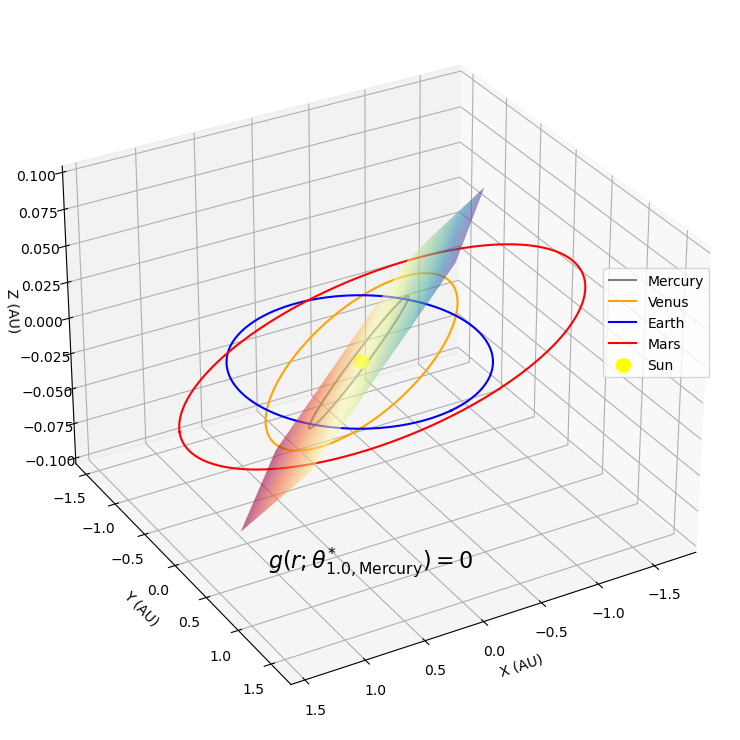

In [4]:
highScoreHyp = get_highScoreHyp(IRAS_runOnCoordinatesResultsDict['Mercury'])
print_IRAS_res(IRAS_runOnCoordinatesResultsDict['Mercury'], highScoreHyp)
plot_manifold(IRAS_runOnCoordinatesResultsDict['Mercury'], highScoreHyp, true_anomaly_values_df, orbitalObs_df, orbitalParams_df, title3D=r'$g(r;\theta^{*}_{1.0,\mathrm{Mercury}})=0$')

## Identifying Mercury’s Orbital Plane with IRAS

We applyed IRAS to Mercury’s 3D heliocentric coordinates and obtained a solution:

$$
\theta^{*}_{1.0,\text{Mercury}} \leftarrow \mathrm{IRAS}(\{r^{\text{Mercury},k}\}_k).
$$

To interpret the learned function $ g(r; \theta^{*}_{1.0,\text{Mercury}}) $, we introduced small perturbations to the input and fit a first-order polynomial. The resulting linear approximation achieves a high **Pearson correlation**, indicating that the learned invariant is nearly linear in $ r $. This implies that the level sets of $ g $ define a **plane in 3D space**.

The normal vector $ \hat{n} $ of this plane is found to be very close to Mercury’s known orbital plane normal, confirming that IRAS has successfully recovered the **orbital plane**—a key geometric feature of Kepler’s first law.

Next, we project Mercury’s 3D coordinates onto this plane to investigate whether the motion is further constrained within it.


In [5]:
alpha = 1e-2
orbitalParams_df['est_orbitalPlaneNormal'] = orbitalParams_df.apply(lambda row: add_est_orbitalPlaneNormal(row, 'Mercury', IRAS_runOnCoordinatesResultsDict['Mercury']['implicitPolyDictList'][0]['coefficients'][1:][:,None], 'est_orbitalPlaneNormal'), axis=1)
orbitalObs_df['r_proj2EstOrbitalPlane'] = orbitalObs_df.apply(lambda row: proj_r_2EstOrbitalPlane(row, orbitalParams_df), axis=1)
orbitalObs_df['r_2D_est'] = orbitalObs_df.apply(lambda row: transform_2_2D(row, orbitalParams_df, np.array([[1], [0], [0]]), est=True), axis=1)
orbitalObs_df['r_2D_est_noisy'] = orbitalObs_df.apply(lambda row: convert_to_r(row, orbitalObs_df, orbitalParams_df, alpha, workOn2D_est=True, est=True), axis=1)

/Users/ron.teichner/Projects/IRAS/kepler_func.py:502: RuntimeWarning: invalid value encountered in divide
  return r - (n.T@r / np.power(np.linalg.norm(n), 2)) * n
/Users/ron.teichner/Projects/IRAS/kepler_func.py:412: RuntimeWarning: invalid value encountered in divide
  u = (np.cross(normal[:,0],a[:,0]) / np.linalg.norm(np.cross(normal[:,0],a[:,0])))[:,None]


In [6]:
if not os.path.exists('IRAS_results.pkl'):
    IRAS_runOnCoordinatesResultsDict = dict()
    enableIRAS_train = True
else:
    IRAS_runOnCoordinatesResultsDict = pickle.load(open('IRAS_results.pkl', 'rb'))
    enableIRAS_train = not 'Mercury2D' in IRAS_runOnCoordinatesResultsDict.keys()
 
if enableIRAS_train:
    IRAS_runOnCoordinatesResultsDict['Mercury2D'] = runIRAS('Mercury', true_anomaly_values_df, orbitalObs_df, orbitalParams_df, runOn2D=True, externalReport=False)

    with open('IRAS_results.pkl', 'wb') as file:
        pickle.dump(IRAS_runOnCoordinatesResultsDict, file)


In [7]:

IRAS_runOnCoordinatesResultsDict['Mercury2D']['implicitPolyDictList'][0]['ellipse_fit']



{'ellipse_eq': '6.6879(x - -0.0776)² + 0.1267(x - -0.0776)(y - 0.0176) + 6.9539(y - 0.0176)²',
 'corr': 0.9140713658570618,
 'ellipse_params': {'A': 6.687892868959824,
  'B': 0.1267422026401974,
  'C': 6.953856640146717,
  'h': -0.07764057617758532,
  'k': 0.01755496070043403},
 'ellipse_rot_angle': -0.2223517791701529,
 'axes_eccentricity': {'a': 0.38709810310954185,
  'b': 0.37882635748955495,
  'e': 0.20562244154023376},
 'focci': ((-0.1552770995656178, 0.03510781056650679),
  (-4.052789552830283e-06, 2.110834361270658e-06))}

Pearson correlation between g() and estimated ellipse is 0.914


/Users/ron.teichner/Projects/IRAS/kepler_func.py:747: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(X, Y, Z, levels=[1], colors='blue', label='fitted ellipse for IRAS g()')


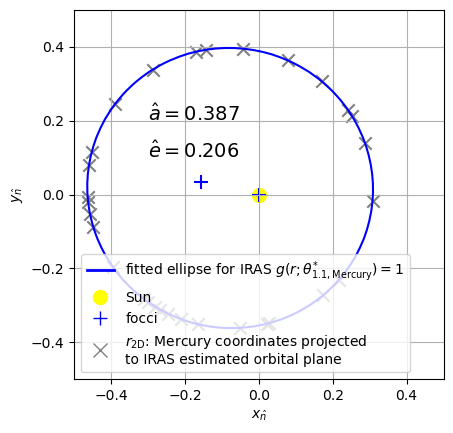

In [8]:
plot_est2D_ellipse(IRAS_runOnCoordinatesResultsDict, 'Mercury', orbitalParams_df, orbitalObs_df, title=r'$g(r; \theta^{*}_{1.1,\mathrm{Mercury}})=1$')

## Fitting an Ellipse to Mercury’s Projected Orbit

After projecting Mercury’s 3D coordinates onto the recovered orbital plane, we applyed IRAS again, now to the resulting 2D data, and obtained a solution:

$$
\theta^{*}_{1.1,\text{Mercury}} \leftarrow \mathrm{IRAS}(r_{\mathrm{2D}}).
$$

To interpret the learned invariant, we fit a rotated ellipse of the form

$$
L(x, y; \mathcal{L}) = \mathcal{L}_1(x - \mathcal{L}_4)^2 + \mathcal{L}_2(x - \mathcal{L}_4)(y - \mathcal{L}_5) + \mathcal{L}_3(y - \mathcal{L}_5)^2
$$

to the neural network output $ g(r_{\mathrm{2D}}; \theta^{*}_{1.1,\text{Mercury}}) $. The fit achieves a high **Pearson correlation**, indicating an excellent match between the learned manifold and the ellipse.

This result confirms that IRAS has successfully recovered **Kepler’s first law**: Mercury’s orbit is an ellipse with the Sun at one focus. Furthermore, the derived **semi-major axis** and **eccentricity** closely match known values (see Table 1 in the manuscript), validating both the accuracy and interpretability of the learned model.


## Discovering Kepler’s Third Law Across Planets

Building on the insight that planetary orbits are elliptical, we now investigate whether a higher-order law governs the **intrinsic parameters** of these ellipses across multiple planets. Specifically, we construct a feature vector for each planet:

$$
l^p := [a^p, e^p, T^p],
$$

where $ a^p $ is the semi-major axis, $ e^p $ is the eccentricity, and $ T^p $ is the orbital period. We then apply IRAS to the set $ \{l^p\}_{p \in \{\text{Mercury, Venus, ...}\}} $, obtaining a solution:

$$
\theta^{*}_{3} \leftarrow \mathrm{IRAS}(\{l^{p}\}_p).
$$

As seen below, The resulting neural network $ g(a, e, T; \theta^{*}_{3}) $ exhibits a high **Pearson correlation** with the expression $ 2\log(T) - 3\log(a) $, effectively rediscovering **Kepler’s third law**. This confirms that the orbital period scales with the $ \frac{3}{2} $ power of the semi-major axis, independent of eccentricity.

This result completes our analysis of orbital observations using IRAS, demonstrating its ability to autonomously recover fundamental physical laws from raw data.

We observe that the values of $T$ span three orders of magnitude, while $a$ and $e$ span two. To account for this variation, we apply a standard feature preprocessing technique and transform these variables using a logarithmic scale. This step is optional; alternatively, a deeper, more expressive model could have been used. However, to maintain efficient run-times and ensure a smooth user experience——we opt for this simple, yet effective, transformation. 


In [9]:
opdf = multi_orbitalParams_df[['a','e','T']]
opdf = opdf.copy()

print(f'a.max()/a.min() = {opdf["a"].max()/opdf["a"].min()}')
print(f'e.max()/e.min() = {opdf["e"].max()/opdf["e"].min()}')
print(f'T.max()/T.min() = {opdf["T"].max()/opdf["T"].min()}')

#opdf['a']=np.log(opdf['a'])
#opdf['e']=np.log(opdf['e'])
#opdf['T']=np.log(opdf['T'])

observations2IRAS = np.log(opdf.to_numpy()[None])
#observations2IRAS = opdf.to_numpy()[None]
observations_tVec = np.repeat(np.arange(observations2IRAS.shape[1])[None,:,None], observations2IRAS.shape[0], 0) 
hypotheses_regulations = None

observations_noisy = observations2IRAS
for featureIdx in range(observations_noisy.shape[2]):
    std = observations2IRAS[:,:,featureIdx].flatten().std()
    observations_noisy[:,:,featureIdx] = observations2IRAS[:,:,featureIdx] + 1e-2*std*np.random.randn(observations2IRAS.shape[0], observations2IRAS.shape[1])

hypotheses_regulations_pearson = (2*observations_noisy[:,:,-1] - 3*observations_noisy[:,:,0])[:,:,None]


a.max()/a.min() = 104.0825438336427
e.max()/e.min() = 254.0176236863009
T.max()/T.min() = 1061.8587335452114


In [10]:
if not os.path.exists('IRAS_results.pkl'):
    IRAS_runOnCoordinatesResultsDict = dict()
    enableIRAS_train = True
else:
    IRAS_runOnCoordinatesResultsDict = pickle.load(open('IRAS_results.pkl', 'rb'))
    enableIRAS_train = not 'k3' in IRAS_runOnCoordinatesResultsDict.keys()


if enableIRAS_train:
    IRAS_results_list = []
    nIRAS_iter=1
    min_CR_naive = np.inf
    for i in range(nIRAS_iter):
        implicitPolyDictList = IRAS_train_script(observations2IRAS, observations_tVec, hypotheses_regulations, seriesForPearson=observations_noisy, hypothesesForPearson=hypotheses_regulations_pearson, titleStr='', nativeIRAS=True, nEpochs=500, degreeOfPolyFit=[1], onlyPolyMixTerms=False, externalReport=False, features2ShuffleTogether=None, playerPerPatient=False)

        IRAS_results_list.append({'planet': '', 'observations2IRAS': observations2IRAS, 'degreeOfPolyFit': [1], 'implicitPolyDictList': implicitPolyDictList})
    
    IRAS_runOnCoordinatesResultsDict['k3'] = IRAS_results_list
    with open('IRAS_results.pkl', 'wb') as file:
        pickle.dump(IRAS_runOnCoordinatesResultsDict, file)

In [11]:
CR_zeta1 = [l['implicitPolyDictList'][0]['CR_zeta1'].item() for l in IRAS_runOnCoordinatesResultsDict['k3']]
corrs = [np.abs(pd.Series(l['implicitPolyDictList'][0]['hypotheses_regulations'].flatten()).corr(pd.Series(l['implicitPolyDictList'][0]['combination'].detach().numpy().flatten()))) for l in IRAS_runOnCoordinatesResultsDict['k3']]
print(f'median of CR = {np.median(np.asarray(CR_zeta1))}')
selectedSolIdx = np.argmin(np.abs(np.median(np.asarray(CR_zeta1)) - np.asarray(CR_zeta1)))
print(f'selectedSolIdx = {selectedSolIdx}')
print(f'corr in selected sol = {corrs[selectedSolIdx]}')


median of CR = 0.021052422001957893
selectedSolIdx = 0
corr in selected sol = 0.8848870162884893


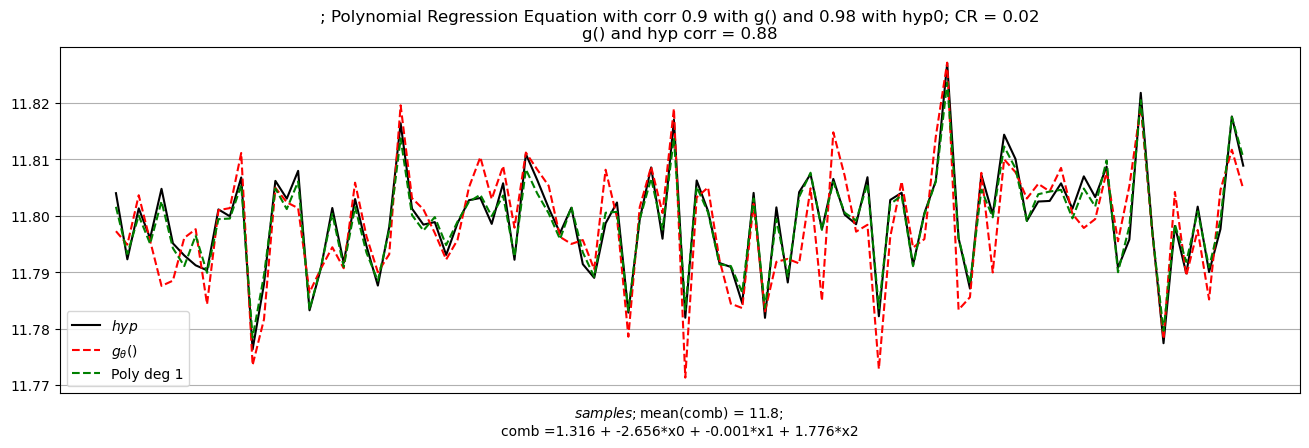

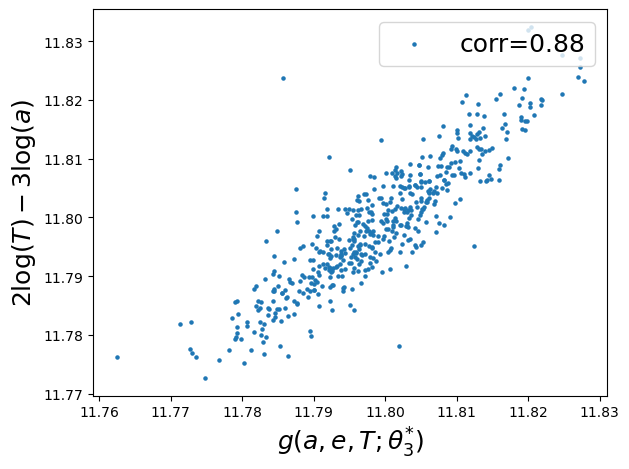

In [12]:

print_IRAS_res(IRAS_runOnCoordinatesResultsDict['k3'][selectedSolIdx], 0, kepler3=True)
